In [14]:
import torch
from torch.utils.data import DataLoader
from dataset import get_years_dataset, train_val_split
import yaml
from model import CNN20
params = yaml.safe_load(open('./params.yaml', 'r')) 
seed = params['global']['seed']
generator = torch.Generator().manual_seed(seed)
device = params['global']['device']
year_start = params['dataset']['year_start']
year_split = params['dataset']['year_split'] 
year_end = params['dataset']['year_end']
ret_days = params['dataset']['ret_days']
ratio = params['dataset']['train_val_split_ratio']
num_workers = params['train']['num_workers'] 
batch_size = params['train']['batch_size']
model_name = 'baseline_I20R5'
model = CNN20()
model.load_state_dict(torch.load(f"./{model_name}_best_model.pth", weights_only=True))
model.to(device)
model.eval()

CNN20(
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), padding=(4, 1), dilation=(2, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=True)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)

In [15]:
train_dataset, val_dataset = train_val_split(get_years_dataset('./monthly_20d', year_start, year_split+1, ret_days), ratio, generator)
test_dataset = get_years_dataset('./monthly_20d', year_split+1, year_end+1, ret_days)
train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers,
)

val_loader = DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
)

test_loader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
)

[INFO]Length of 1993-1999 datasets: 693037
693037
[INFO]Length of 2000-2019 datasets: 1497687


In [16]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F   
model.to(device)
TP = TN = FP = FN = 0
model.eval()
for i, (images, labels) in tqdm(enumerate(test_loader)):
            images = images.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(images)
            _, pred = torch.max(outputs, dim=1)
            TP += ((pred == labels) & (labels == 1)).sum()
            TN += ((pred == labels) & (labels == 0)).sum()
            FP += ((pred != labels) & (labels == 0)).sum()
            FN += ((pred != labels) & (labels == 1)).sum()
TOT = TP + TN + FP + FN

11701it [00:38, 301.21it/s]


In [ ]:
Accuracy = (TP + TN) / TOT
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)
print(f"Accuracy: {Accuracy:.4f}")
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.5302
TP: 355259, TN: 438811, FP: 296658, FN: 406959
Precision: 0.5449
Recall: 0.4661
F1 Score: 0.5024


: 

            Date StockID   MarketCap        Ret_5d   Ret_20d   Ret_60d  \
0     2017-01-31   10001    133078.0  4.370390e-07 -0.000002 -0.005954   
1     2017-02-28   10001    133078.0  3.951997e-03  0.002795  0.009953   
2     2017-03-31   10001    133604.0 -7.874612e-03 -0.015749  0.021723   
3     2017-04-28   10001    131500.0  9.999880e-03  0.016001  0.038072   
4     2017-05-31   10001    133604.0  4.370390e-07  0.021722       NaN   
...          ...     ...         ...           ...       ...       ...   
67853 2017-08-31   93436  59395080.0 -3.512252e-02 -0.041584 -0.109835   
67854 2017-09-29   93436  57310600.0  4.626140e-02 -0.059308 -0.069807   
67855 2017-10-31   93436  55719252.0 -7.685617e-02 -0.072363  0.054292   
67856 2017-11-30   93436  51907496.0  7.737713e-03  0.008093  0.110766   
67857 2017-12-29   93436  52554948.0  8.048780e-02  0.110713 -0.172055   

       Ret_month  EWMA_vol  
0      -0.000002  0.000450  
1       0.009953  0.000180  
2      -0.015749  0.0000

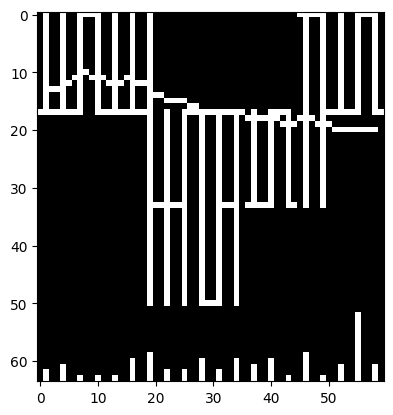

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
year = 2017
dir = './monthly_20d'
labels_path = os.path.join(f'{dir}/20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather')
labels_df = pd.read_feather(labels_path)

IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96} 

images_path = os.path.join(f'{dir}/20d_month_has_vb_[20]_ma_{2017}_images.dat')
images = np.memmap(images_path, dtype=np.uint8, mode='r')
images = images.reshape((-1,1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
plt.imshow(np.squeeze(images[1]), cmap='gray')

print(labels_df)

In [53]:
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
dir = './monthly_20d'
IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}    
model.eval()
count = 0 
output = []
with torch.no_grad():
    for year in range(2000, 2020):
        images_path = os.path.join(f'{dir}/20d_month_has_vb_[20]_ma_{year}_images.dat')
        images = np.memmap(images_path, dtype=np.uint8, mode='r')
        images = images.reshape((-1,1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
        count += images.shape[0]
    for i in range(images.shape[0]):
        image = images[i].copy()
        image = torch.from_numpy(image).to(device)
        image = image.float()
        output.append(model(image.unsqueeze(0)).cpu().numpy())

In [ ]:
import os
import numpy as np
from torch.utils.data import DataLoader, Dataset
dir = './monthly_20d'
IMAGE_WIDTH = {5: 15, 20: 60, 60: 180}
IMAGE_HEIGHT = {5: 32, 20: 64, 60: 96}    
model.eval()
count = 0 
dfs = []
with torch.no_grad():
    for year in range(2000, 2020):
        labels_path = os.path.join(f'{dir}/20d_month_has_vb_[20]_ma_{year}_labels_w_delay.feather')
        images_path = os.path.join(f'{dir}/20d_month_has_vb_[20]_ma_{year}_images.dat')
        images = np.memmap(images_path, dtype=np.uint8, mode='r')
        images = images.reshape((-1,1, IMAGE_HEIGHT[20], IMAGE_WIDTH[20]))
        labels_df = pd.read_feather(labels_path)
        labels = labels_df[f'Ret_{ret_days}d']
        missing = labels.isna()
        print(f"Year {year}: Found {missing.sum()} missing labels.")
        filtered_df = labels_df[~missing].copy()
        if 'year' not in filtered_df.columns:
            filtered_df['year'] = year
        dfs.append(filtered_df)
        print(f"Year {year}: Added {len(filtered_df)} records with non-missing return values.")
df = pd.concat(dfs, ignore_index=True)
print(f"Successfully created combined DataFrame with {len(df)} total records")

Year 2000: Found 394 missing labels.
Year 2000: Added 97754 records with non-missing return values.
Year 2001: Found 346 missing labels.
Year 2001: Added 91639 records with non-missing return values.
Year 2002: Found 261 missing labels.
Year 2002: Added 85468 records with non-missing return values.
Year 2003: Found 239 missing labels.
Year 2003: Added 80655 records with non-missing return values.
Year 2004: Found 208 missing labels.
Year 2004: Added 79304 records with non-missing return values.
Year 2005: Found 231 missing labels.
Year 2005: Added 79652 records with non-missing return values.
Year 2006: Found 233 missing labels.
Year 2006: Added 79930 records with non-missing return values.
Year 2007: Found 326 missing labels.
Year 2007: Added 80814 records with non-missing return values.
Year 2008: Found 378 missing labels.
Year 2008: Added 77808 records with non-missing return values.
Year 2009: Found 180 missing labels.
Year 2009: Added 69885 records with non-missing return values.


In [81]:
all_predictions = []
model.eval()
with torch.no_grad(): 
    for i, (images, labels) in tqdm(enumerate(test_loader)):
        images = images.to(device)
        predictions = F.softmax(model(images), dim=1)
        all_predictions.append(predictions.cpu().numpy()) 

final_predictions = np.concatenate(all_predictions, axis=0)
print(final_predictions)
print(final_predictions.shape)

11701it [00:47, 248.22it/s]

[[0.51771796 0.48228204]
 [0.56659216 0.4334078 ]
 [0.4586978  0.5413022 ]
 ...
 [0.5462434  0.45375657]
 [0.5095201  0.4904799 ]
 [0.40733334 0.5926667 ]]
(1497687, 2)


In [ ]:
df_with_pred = df.copy()
df_with_pred[f'pred_{ret_days}d'] = final_predictions[:, 1]
df_with_pred['StockID'] = df_with_pred['StockID'].astype('category')
portfolio_returns = []
annualization_factor = 252 / ret_days
for date, date_group in df_with_pred.groupby('Date'):
    #print(f"Date: {date}")
    #print(date_group[['StockID', f'Ret_{ret_days}d', f'pred_{ret_days}d']].head(10))
    date_group['decile'] = pd.qcut(date_group[f'pred_{ret_days}d'], 10, labels=False) + 1
    value_weighted_returns = {}
    for decile, decile_group in date_group.groupby('decile'):
            # Use absolute values for market cap to handle negative values
            total_market_cap = decile_group['MarketCap'].abs().sum()
            decile_group['weight'] = decile_group['MarketCap'].abs() / total_market_cap
            value_weighted_returns[decile] = (decile_group[f"Ret_{ret_days}d"] * decile_group['weight']).sum()
    value_decile_returns = pd.Series(value_weighted_returns)
    decile_returns = date_group.groupby('decile')[f'Ret_{ret_days}d'].mean()
    hl_return = decile_returns.iloc[9] - decile_returns.iloc[0]
    value_hl_return = value_decile_returns.get(10, 0) - value_decile_returns.get(1, 0)

    result = {'Date': date}
    for i in range(1, 11):
        result[f'Equal-Weight_D{i}'] = decile_returns.get(i, np.nan)
        result[f'Value-Weight_D{i}'] = value_decile_returns.get(i, np.nan)
    result['Equal-Weight_H-L'] = hl_return
    result['Value-Weight_H-L'] = value_hl_return
    portfolio_returns.append(result)
portfolio_returns = pd.DataFrame(portfolio_returns)  
print(portfolio_returns)

avg_returns = {col: portfolio_returns[col].mean() for col in portfolio_returns.columns if col != 'Date'} # returns per periodic
avg_annualized_returns = {col: ret * annualization_factor for col, ret in avg_returns.items()} # annualized returns
print("Average Returns:", avg_returns)
print("Average Annualized Returns:", avg_annualized_returns)

          Date  Equal-Weight_D1  Value-Weight_D1  Equal-Weight_D2  \
0   2000-01-31         0.012843        -0.005811         0.031171   
1   2000-02-29         0.001189        -0.003515         0.031863   
2   2000-03-31        -0.041435        -0.063153        -0.029527   
3   2000-04-28        -0.003569         0.008126        -0.002547   
4   2000-05-31         0.016829         0.041189         0.042706   
..         ...              ...              ...              ...   
235 2019-08-30         0.009135         0.025464         0.020704   
236 2019-09-30        -0.024527        -0.010425        -0.017461   
237 2019-10-31         0.001681        -0.005526         0.008579   
238 2019-11-29        -0.009434         0.006945         0.001252   
239 2019-12-31         0.004929         0.000222         0.006255   

     Value-Weight_D2  Equal-Weight_D3  Value-Weight_D3  Equal-Weight_D4  \
0           0.028903         0.046331         0.030648         0.053292   
1           0.010540 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from model import CNN20
class CNN20(nn.Module):
    def __init__(self,
                drop_out=0.5,
                layers=3,
                batch_normalization=True,
                xavier_initialization=True,
                conv_filters=64,
                kernel_sizes=[5, 3],
                strides=[3, 1],
                dilation=[2, 1],
                activation="LReLu"):
        super(CNN20, self).__init__()
        
        # Convert lists to tuples for kernel sizes, strides, and dilation
        self.kernel_sizes = tuple(kernel_sizes) if isinstance(kernel_sizes, list) else kernel_sizes
        self.strides = tuple(strides) if isinstance(strides, list) else strides
        self.dilation = tuple(dilation) if isinstance(dilation, list) else dilation
        
        # Store other parameters
        self.drop_out = drop_out
        self.activation_type = activation.lower()
        self.conv_filters = conv_filters
        self.layers = layers
        self.batch_normalization = batch_normalization
        self.xavier_initialization = xavier_initialization
        
        # Calculate number of filters for each layer
        self.filters = [1] + [conv_filters * (2 ** i) for i in range(layers)]
        
        # Create activation function
        self.activation = self._get_activation()
        
        # Create convolutional blocks
        self.blocks = nn.ModuleList()
        dummy_input = torch.randn(1, 1, 64, 60)
        for i in range(layers):
            if i == 0:
                padding_h = self._calculate_padding(
                    kernel_size=self.kernel_sizes[0], 
                    stride=self.strides[0],           
                    dilation=self.dilation[0]         
                )
                padding_w = self._calculate_padding(
                    kernel_size=self.kernel_sizes[1],  
                    stride=self.strides[1],          
                    dilation=self.dilation[1]        
                )
            else:
                padding_h = (self.kernel_sizes[0] - 1) // 2
                padding_w = (self.kernel_sizes[1] - 1) // 2

            in_channels = self.filters[i]
            out_channels = self.filters[i+1]

            block = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=self.kernel_sizes,
                    stride=self.strides if i == 0 else (1, 1),
                    dilation=self.dilation if i == 0 else (1, 1),
                    padding=(padding_h, padding_w)
                ),
                nn.BatchNorm2d(out_channels) if self.batch_normalization else nn.Identity(),
                self.activation,
                nn.MaxPool2d(
                    kernel_size=(2, 1),
                    ceil_mode=True
                )
            )
            dummy_input = block(dummy_input)
            self.blocks.append(block)
        fc_input_dim = dummy_input.size(1) * dummy_input.size(2) * dummy_input.size(3)
        self.fc = nn.Sequential(
            nn.Dropout(self.drop_out),
            nn.Linear(fc_input_dim, 1)
        )
        self.apply(self._init_weights)
    
    def _calculate_output_dim(self, input_dim, kernel_size, stride, dilation):
        return (input_dim - kernel_size + 2 * self._calculate_padding(kernel_size, stride, dilation)) // stride
    
    def _calculate_padding(self, kernel_size, stride, dilation):
        return ((stride - 1) + dilation * (kernel_size - 1)) // 2
    
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.fc(x.view(x.size(0), -1))
        return x
    
    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight) if self.xavier_initialization else init.zeros_(m.weight)
        if isinstance(m, nn.Linear):
            init.xavier_uniform_(m.weight) if self.xavier_initialization else init.zeros_(m.weight)
            init.zeros_(m.bias)
    
    def _get_activation(self):
        activation_map ={
            "lrelu": nn.LeakyReLU(0.01),
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "gelu": nn.GELU(),
            "elu": nn.ELU(),
            "selu": nn.SELU(),
            "celu": nn.CELU(),
            "gelu": nn.GELU(),
        }
        if self.activation_type not in activation_map:
            raise ValueError(f"Activation type {self.activation_type} not supported")
        return activation_map[self.activation_type]


from torch.utils.data import DataLoader
import yaml
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import pandas as pd
from dataset import get_years_dataset, train_val_split
from train_utils import trainer
import argparse
import os

config = yaml.safe_load(open('config.yaml', 'r'))
model = CNN20(**config)
train_dataset, val_dataset = train_val_split(get_years_dataset('./monthly_20d/', 1993, 2001, 20, regression=True), 0.7, False)
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,
)   

total_training_parameters = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        total_training_parameters += param.numel()
print(f"[INFO]Number of training parameters: {total_training_parameters}")

optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()
model.to('cuda')
model, metrics_df = trainer(model, train_loader, val_loader, criterion, optimizer, 50, 'cuda',
                                                    2, 0, 'ckpt', 'regression')
torch.save(model.state_dict(), os.path.join('model', f'{'regression'}.pth'))
metrics_df.to_csv(f'{'output'}/{'regression'}_metrics.csv', index=False)
print(f"[INFO]Training losses saved to {'output'}/{'regression'}_metrics.csv")

[INFO]Length of 1993-2000 datasets: 786765
[INFO]Number of training parameters: 662785
[INFO]Training on cuda!


0it [00:00, ?it/s]/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
4301it [00:38, 106.28it/s]/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([79])) that is different to the input size (torch.Size([79, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
4303it [00:38, 112.39it/s]


Epoch [1/50], Training_Loss: 1.1409


1827it [00:06, 294.26it/s]/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([126])) that is different to the input size (torch.Size([126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
1844it [00:06, 278.08it/s]


Epoch [1/50], Validation Loss: 0.0618
Epoch [1/50], Checkpoint saved at ckpt/regression_1.pth


4303it [00:40, 107.28it/s]


Epoch [2/50], Training_Loss: 0.3133


1844it [00:06, 274.41it/s]


Epoch [2/50], Validation Loss: 0.0455
Epoch [2/50], Checkpoint saved at ckpt/regression_2.pth


4303it [00:41, 104.90it/s]


Epoch [3/50], Training_Loss: 0.1342


1844it [00:07, 257.32it/s]


Epoch [3/50], Validation Loss: 0.0403
Epoch [3/50], Checkpoint saved at ckpt/regression_3.pth


4303it [00:41, 103.39it/s]


Epoch [4/50], Training_Loss: 0.0767


1844it [00:06, 288.73it/s]


Epoch [4/50], Validation Loss: 0.0411
Early_Stopping Counter: 1 / 2
Epoch [4/50], Checkpoint saved at ckpt/regression_4.pth


4303it [00:40, 106.37it/s]


Epoch [5/50], Training_Loss: 0.0530


1844it [00:06, 291.14it/s]


Epoch [5/50], Validation Loss: 0.0389
Epoch [5/50], Checkpoint saved at ckpt/regression_5.pth


4303it [00:38, 111.93it/s]


Epoch [6/50], Training_Loss: 0.0441


1844it [00:06, 288.08it/s]


Epoch [6/50], Validation Loss: 0.0389
Early_Stopping Counter: 1 / 2
Epoch [6/50], Checkpoint saved at ckpt/regression_6.pth


4303it [00:40, 106.19it/s]


Epoch [7/50], Training_Loss: 0.0413


1844it [00:06, 286.67it/s]


Epoch [7/50], Validation Loss: 0.0387
Epoch [7/50], Checkpoint saved at ckpt/regression_7.pth


4303it [00:40, 106.64it/s]


Epoch [8/50], Training_Loss: 0.0404


1844it [00:07, 255.12it/s]


Epoch [8/50], Validation Loss: 0.0387
Early_Stopping Counter: 1 / 2
Epoch [8/50], Checkpoint saved at ckpt/regression_8.pth


4303it [00:39, 110.19it/s]


Epoch [9/50], Training_Loss: 0.0401


1844it [00:06, 275.65it/s]

Epoch [9/50], Validation Loss: 0.0388
Early_Stopping Counter: 2 / 2
[INFO]Early_Stopping is triggered!
[INFO]Early stopping at epoch 9
[INFO]Best epoch: 7
[INFO]Best validation loss: 0.0387
[INFO]Training complete in 6m 60s
[INFO]Training losses saved to output/regression_metrics.csv



/root/autodl-tmp/MATH5470_Final_proj/train_utils.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(ckpt_path, f'{name}_{re

In [ ]:
pd.read_feather('monthly_20d/20d_month_has_vb_[20]_ma_2018_labels_w_delay.feather').head(8)

,Date,StockID,MarketCap,Ret_5d,Ret_20d,Ret_60d,Ret_month,EWMA_vol
0,2019-01-31,10026,2899156.25,0.013346,0.008357,0.009807,0.006025,0.000988
1,2019-02-28,10026,2916624.25,-0.021123,0.029734,0.050473,0.026309,0.000424
2,2019-03-29,10026,2988574.50,-0.024616,-0.021972,0.025677,-0.010451,0.000209
3,2019-04-30,10026,2957655.75,0.020867,0.018959,0.031149,0.023349,0.000136
4,2019-05-31,10026,3026714.75,0.020018,0.003693,0.192524,0.003693,0.000105
5,2019-06-28,10026,3030688.50,0.014726,0.013980,0.193034,0.154645,0.000118
6,2019-07-31,10026,3501411.50,-0.005218,0.017329,0.025586,0.038852,0.000963
7,2019-08-30,10026,3637443.50,0.001864,-0.002902,-0.030323,-0.002902,0.000440
